**Diabetes detection**

This notebook illustrates how we can use features of a person to detect if the person has diabetes or not. We will use the dataset `data_for_training.csv` to train a model. Afterwards, we will perform inference on `data_for_inference.csv` and reflect about our observations. Before you start, you should upload all relevant files which are in the folder diabetes_detection in your repository to the Colab environment. The requirement is to reach an accuracy of 85% or higher. Let us now install all relevant dependecies:

In [5]:
!pip install virtualenv

Let us create a venv called `venv_diabetes` for our use case and activate it:

In [ ]:
!virtualenv venv_diabetes

In [7]:
!source venv_diabetes/bin/activate

Now we can install all dependencies into the avtivated venv:

In [ ]:
!pip install -r requirements.txt


Let us load the data for training. You should upload all relevant files of the repository to the colab environment

In [12]:
import pandas as pd
def get_csv_data(file_name):
  df = pd.read_csv(file_name)
  return df

In [13]:
df = get_csv_data('data_for_training.csv')

We will perform some EDA:

In [14]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,36.0,0,0,current,23.45,5.0,155,0
1,Male,76.0,1,1,current,20.14,4.8,155,0
2,Female,44.0,0,0,never,19.31,6.5,200,1
3,Female,79.0,0,0,No Info,23.86,5.7,85,0
4,Male,5.0,0,0,No Info,18.80,6.2,85,0


In [15]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,26578.000000,26578.000000,26578.000000,26578.000000,26578.000000,26578.000000,26578.000000
mean,27.892820,0.029235,0.019678,19.893527,5.433268,134.092106,0.024983
std,23.901879,0.168467,0.138894,2.880835,1.009476,36.250515,0.156076
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,7.000000,0.000000,0.000000,17.620000,4.800000,100.000000,0.000000
50%,20.000000,0.000000,0.000000,20.400000,5.800000,140.000000,0.000000
75%,45.000000,0.000000,0.000000,22.380000,6.200000,158.000000,0.000000
max,80.000000,1.000000,1.000000,24.000000,9.000000,300.000000,1.000000


Let's explore the variable types. Those that are categorical will have to be transformed to numerical prior to calculate the correlation.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26578 entries, 0 to 26577
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               26578 non-null  object 
 1   age                  26578 non-null  float64
 2   hypertension         26578 non-null  int64  
 3   heart_disease        26578 non-null  int64  
 4   smoking_history      26578 non-null  object 
 5   bmi                  26578 non-null  float64
 6   HbA1c_level          26578 non-null  float64
 7   blood_glucose_level  26578 non-null  int64  
 8   diabetes             26578 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 1.8+ MB


Before we continue, we need to transform the features `gender` and `smoking_history` since they are of type `object`. Several strategies are valid for this task:

1. One-Hot Encoding: This is one of the most common methods. It creates new binary columns for each category/label present in the original column. For example, for a column "Color" with values "Red", "Blue", "Green", one-hot encoding will create three new columns, one for each color, and will put 1 in the column that corresponds to the correct color and 0 in the others.
2. Ordinal Encoding: This is another common method, especially useful when there is a clear ranking in the categories. For instance, if you have a feature like "Size" with values "Small", "Medium", "Large", these can be respectively encoded as 1, 2, 3.
3. Binary Encoding: This method first encodes the categories as ordinal, then converts the integers into binary code, then splits the digits from that binary string into separate columns. This can be particularly effective when dealing with high cardinality data where one-hot encoding will expand the data dimensionality significantly.
4. (...)

| Column1 | Column2 | (old label) |
|---------|---------|-------------|
| 0       |    1    | (Red)       |
| 1       |    0    | (Blue)      |
| 1       |    1    | (Green)     |
| 1       |    0    | (Yellow)    |

Check class imbalance:

In [21]:
print(f"Diabetes subset = {round(len(df[df['diabetes'] == 1]) / len(df), 2)}%")


Diabetes subset = 0.02%


The dataset is unbalanced. Let's fix it (in this case by down sampling).

NOTE: there are many strategies to deal with unbalanced dataset, but for the sake of the exercise we are not going to go deeper into them. The `data.py` file contains a helper function `balance_binary_classes` which is balancing the dataset by down sampling. Also, we will import some other helper functions from the file `graphs.py` which we will use later.

In [22]:
import pandas as pd

from data import balance_binary_classes
from graphs import (
    plot_correlation,
    display_metrics,
    plot_confusion_matrix
)

In [23]:
df_balanced = balance_binary_classes(df, 'diabetes')

Now we can start the training:

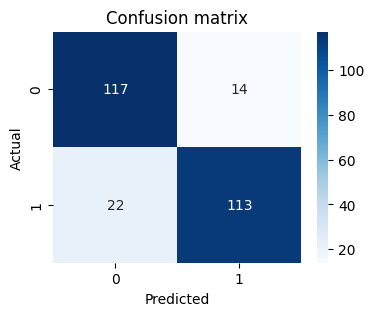

,Score
Accuracy,0.864662
Precision,0.889764
Recall,0.837037
F1,0.862595


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix

# Separate the features and the target
X = df_balanced.drop(columns=['diabetes'])
y = df_balanced['diabetes']

# Define a preprocessor for column transformations
gender_categories = df['gender'].unique().tolist()
smoking_history_categories = df['smoking_history'].unique().tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']),
        ('cat', OneHotEncoder(categories=[gender_categories, smoking_history_categories]), ['gender', 'smoking_history'])
    ])


# Fit and transform the features
X_processed = preprocessor.fit_transform(X)

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Create a Logistic Regression object
lr = LogisticRegression()

# Fit the model to the training data
lr.fit(X_train, y_train)

# Now you can make predictions on new data or the test data
predictions = lr.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Call the function to plot the confusion matrix
plot_confusion_matrix(conf_matrix)

# Call the function to display the metrics
display_metrics(y_test, predictions)

### Congratulations!!!. Your model is performing very good on the test dataset. The requirements are fulfilled.

Now we do inference on the new dataset `data_for_inference.csv`

In [25]:
df_new = get_csv_data('data_for_inference.csv')

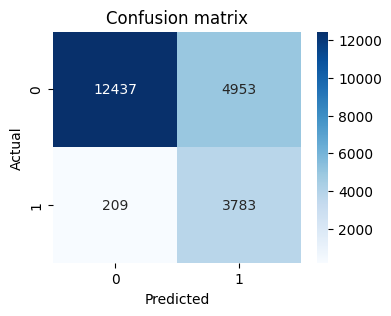

,Score
Accuracy,0.758582
Precision,0.433036
Recall,0.947645
F1,0.594437


In [26]:
# separate the features and the target
X_new = df_new.drop(columns=['diabetes'])
y_new = df_new['diabetes']

# Fit and transform the features
X_new_processed = preprocessor.transform(X_new)

# Now you can make predictions on new data or the test data
predictions_new = lr.predict(X_new_processed)

# Calculate confusion matrix
conf_matrix_new = confusion_matrix(y_new, predictions_new)

# Call the function to plot the confusion matrix
plot_confusion_matrix(conf_matrix_new)

# Call the function to display the metrics
display_metrics(y_new, predictions_new)

The model is not fulfilling the requirements anymore. What happened?

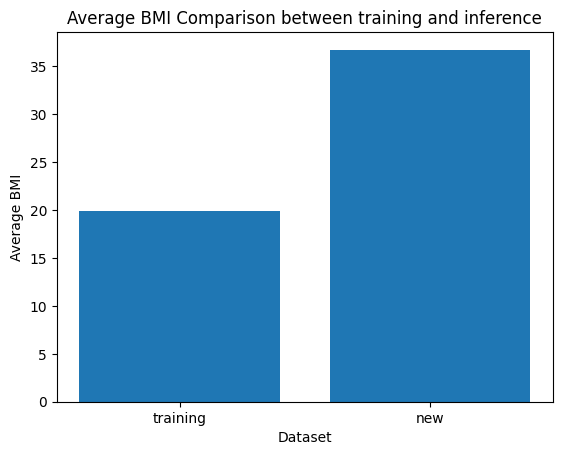

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Compute average BMI for df_1 and df_2
average_bmi_df1 = df['bmi'].mean()
average_bmi_df2 = df_new['bmi'].mean()

# Plot the different BMI values
plt.bar(['training', 'new'], [average_bmi_df1, average_bmi_df2])
plt.xlabel('Dataset')
plt.ylabel('Average BMI')
plt.title('Average BMI Comparison between training and inference')
plt.show()

In [28]:
df_all = pd.concat([df, df_new])

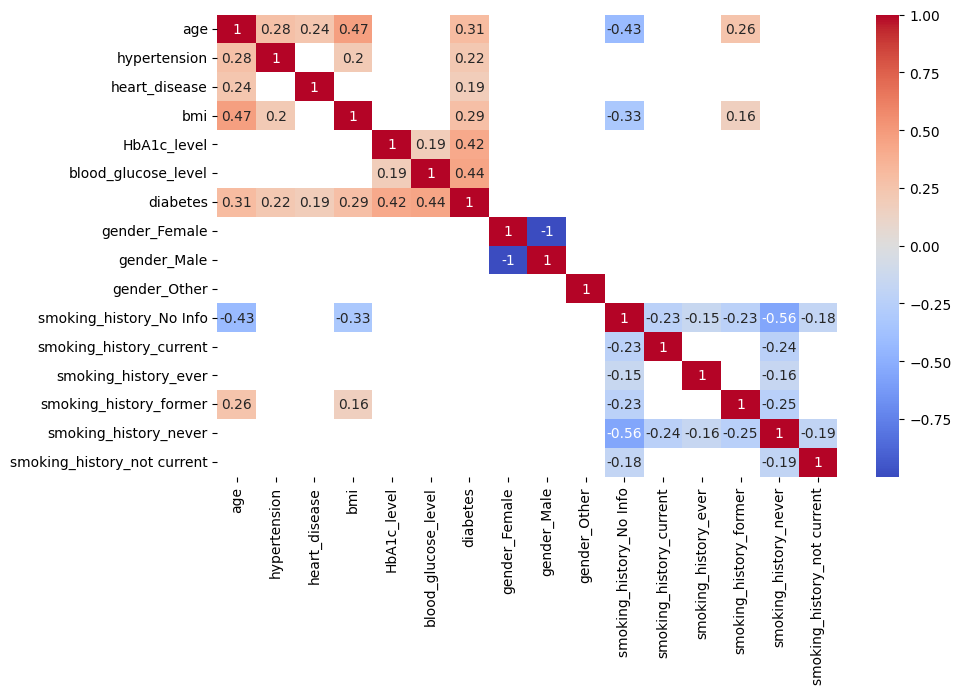

In [29]:
df_encoded = pd.get_dummies(df_all, columns=['gender', 'smoking_history'])
# NOTE: be careful to don't include hierarchy in your features, such as gender for example (Male=0, Female=1).
# This could lead to a miss interpretations when doing your correlations in this case as Female would be more than Male.
# One-Hot encoding will prevent you to make mistakes in these cases.

# Plot the correlation graph using our helper function
plot_correlation(df_encoded, thresh=0.15)

We see a positive correlation between bmi and diabetes. But the bmi distribution at training time has been different compared to the bmi distribution at inference time. This could explain the poor performance of our model at inference time. How can we detect this early? How can we fix this?